# Time Series Analysis using Deep Learning to map changes in illegal gold mining

## Exporting data from GEE to Google Drive

In [1]:
# We will start importing the GEE library
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=-ggpvK5kdcYC8PVrzX9bF0Z7LIVPaFJ6rY5bPwxMh5E&tc=IcaYRVzJR_UXXloA4_68sDyqC9CvWXt1n81N_O96su4&cc=W8FVFBBrKN4xGzJhSi5xmknZddnx8QfPW0dX0dLdeIc

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1Adeu5BVq4vrg2q35FOUqJalYgdomy52qZpBbDRzIrLNCU85yEIaaIHt_cSc

Successfully saved authorization token.


In [2]:
# We will mount our Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# We will utilize TensorFlow for training the model
import tensorflow as tf
# Numpy to perform numerical operations
import numpy as np
# Time to quantify the amount of time the predictions tkae
import time
# Gdal to codify the final image
from osgeo import gdal
# Matplotlib to plot our results
import matplotlib.pyplot as plt
# We will print the current version of tensorflow
print(tf.__version__)

2.12.0


In [4]:
# We will load the feature collection that contains the data using the GEE API
fc = ee.FeatureCollection('projects/ACCA-SERVIR/RAMI_DL/Annual_2022')

# We will also import the Sentinel-1 collection
s1 = ee.ImageCollection("COPERNICUS/S1_GRD")

In [5]:
# We will print the loaded feature collection
print(fc.size().getInfo())

300


In [6]:
# We will filter the confirmed mining points
filteredFC = fc.filter([ee.Filter.eq('Mining', 'Yes'), ee.Filter.eq('Confimad', 'YES')])
print(filteredFC.size().getInfo())
print(filteredFC.first().getInfo())

62
{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [-70.58795315873886, -12.840382802492218]}, 'id': '000000000000000000cc', 'properties': {'Confimad': 'YES', 'Date': 40, 'Fecha': 1620198000000, 'Imagery': 'Planet NICFI', 'Mes_Imagen': '', 'Mining': 'Yes', 'lat': -12.840383923911821}}


In [7]:
# Now we will create a function that will be mapped into our feature collection
def getImgCol (feat):
  imgDate = ee.Date(feat.get('Fecha'))
  filtered = s1.filter([ee.Filter.bounds(feat.geometry()),
                        ee.Filter.date(imgDate.advance(-2, 'month'), imgDate.advance(1, 'day')),
                        ee.Filter.eq('relativeOrbitNumber_start', 149),
                        ee.Filter.eq('orbitProperties_pass', 'ASCENDING')]).select(['VV', 'VH'])
  listFiltered = filtered.toList(3, 3)
  arrayCol = ee.Algorithms.If(ee.Number(listFiltered.size()).eq(3),
                              ee.ImageCollection(listFiltered).toArrayPerBand()
                              .set('imgID_1', ee.Image(listFiltered.get(0)).get('system:index'))
                              .set('imgID_2', ee.Image(listFiltered.get(1)).get('system:index'))
                              .set('imgID_3', ee.Image(listFiltered.get(2)).get('system:index')),
                              None)
  return arrayCol

In [8]:
# We will apply the created function to our feature collection
imgCol = filteredFC.map(getImgCol, True)
print(imgCol.size().getInfo())
print(imgCol.first().getInfo())

43
{'type': 'Image', 'bands': [{'id': 'VV', 'data_type': {'type': 'PixelType', 'precision': 'double', 'dimensions': 1}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'VH', 'data_type': {'type': 'PixelType', 'precision': 'double', 'dimensions': 1}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}], 'properties': {'imgID_1': 'S1B_IW_GRDH_1SDV_20210411T230820_20210411T230845_026425_032797_776D', 'imgID_2': 'S1B_IW_GRDH_1SDV_20210423T230821_20210423T230846_026600_032D36_6C17', 'imgID_3': 'S1B_IW_GRDH_1SDV_20210505T230821_20210505T230846_026775_0332CE_F1CB', 'system:index': '000000000000000000cc'}}


In [9]:
# Now we will create another function that will set the label
def setLabel (feat):
  index = feat.get('system:index')
  condition = ee.Algorithms.If(imgCol.filter(ee.Filter.eq('system:index', index)).size().eq(1), feat, None)
  return condition

In [10]:
# We will map the created function to our feature collection
finalFC = filteredFC.map(setLabel, True)
print(finalFC.size().getInfo())
print(finalFC.first().getInfo())

43
{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [-70.58795315873886, -12.840382802492218]}, 'id': '000000000000000000cc', 'properties': {'Confimad': 'YES', 'Date': 40, 'Fecha': 1620198000000, 'Imagery': 'Planet NICFI', 'Mes_Imagen': '', 'Mining': 'Yes', 'lat': -12.840383923911821}}


In [11]:
print(finalFC.first().getInfo())

{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [-70.58795315873886, -12.840382802492218]}, 'id': '000000000000000000cc', 'properties': {'Confimad': 'YES', 'Date': 40, 'Fecha': 1620198000000, 'Imagery': 'Planet NICFI', 'Mes_Imagen': '', 'Mining': 'Yes', 'lat': -12.840383923911821}}


In [12]:
# Now we will create another function to sample
def sampling (feat):
  index = feat.get('system:index')
  selected = imgCol.filter(ee.Filter.eq('system:index', index)).first()
  sample = ee.Image(selected).sampleRegions(**{
      "collection": ee.FeatureCollection(feat),
      "scale": 10,
      "projection": 'EPSG:32719',
      "geometries": False
      }).first().copyProperties(ee.Image(selected)).set('label', ee.Array([[0],[0],[1]]))
  return sample

In [13]:
# We will map the function, to obtain points
samplePoints = finalFC.map(sampling).randomColumn()
print(samplePoints.first().getInfo())

{'type': 'Feature', 'geometry': None, 'id': '000000000000000000cc', 'properties': {'Confimad': 'YES', 'Date': 40, 'Fecha': 1620198000000, 'Imagery': 'Planet NICFI', 'Mes_Imagen': '', 'Mining': 'Yes', 'VH': [-17.710720414755848, -14.099343448271425, -16.19333393541844], 'VV': [-6.028237031206864, -12.006012553928688, -7.994074031706704], 'imgID_1': 'S1B_IW_GRDH_1SDV_20210411T230820_20210411T230845_026425_032797_776D', 'imgID_2': 'S1B_IW_GRDH_1SDV_20210423T230821_20210423T230846_026600_032D36_6C17', 'imgID_3': 'S1B_IW_GRDH_1SDV_20210505T230821_20210505T230846_026775_0332CE_F1CB', 'label': [[0], [0], [1]], 'lat': -12.840383923911821, 'random': 0.18291975204489874}}


In [14]:
# Now we will define our train, test and validation datasets
train_data = samplePoints.filter(ee.Filter.lte('random', 0.70))
val_data = samplePoints.filter(ee.Filter.And(ee.Filter.gt('random', 0.70), ee.Filter.lte('random', 0.90)))
test_data = samplePoints.filter(ee.Filter.gt('random', 0.90))

print('Train: ', train_data.size().getInfo())
print('Val: ', val_data.size().getInfo())
print('Test: ', test_data.size().getInfo())

Train:  36
Val:  5
Test:  2


In [15]:
# Time to export our data to Google Drive!
csvTask = ee.batch.Export.table.toDrive(**{
    "collection": samplePoints,
    "description": 'RAMI_LSTM_Data',
    "folder": 'RAMI_DL',
    "fileNamePrefix": 'RAMI_DL_Data',
    "fileFormat": 'CSV'
})
trainTask = ee.batch.Export.table.toDrive(**{
    "collection": train_data,
    "description": 'RAMI_LSTM_Train',
    "folder": 'RAMI_DL',
    "fileNamePrefix": 'RAMI_DL_Train',
    "fileFormat": 'TFRecord',
    "selectors": ['VV', 'VH', 'label']
})
valTask = ee.batch.Export.table.toDrive(**{
    "collection": val_data,
    "description": 'RAMI_LSTM_Validation',
    "folder": 'RAMI_DL',
    "fileNamePrefix": 'RAMI_DL_Val',
    "fileFormat": 'TFRecord',
    "selectors": ['VV', 'VH', 'label']
})
testTask = ee.batch.Export.table.toDrive(**{
    "collection": test_data,
    "description": 'RAMI_LSTM_Test',
    "folder": 'RAMI_DL',
    "fileNamePrefix": 'RAMI_DL_Test',
    "fileFormat": 'TFRecord',
    "selectors": ['VV', 'VH', 'label']
})

In [16]:
# Now that our tasks are define, let's run them!
# It will take less than 2 minutes to export our data to Google Drive
csvTask.start()
trainTask.start()
valTask.start()
testTask.start()

## Exporting a small image to perform predictions

In [17]:
# We will also export an image stack, to later perform predictions
imgID_1 = ee.Image('COPERNICUS/S1_GRD/S1A_IW_GRDH_1SDV_20220903T230939_20220903T231004_044846_055B25_AEB4')
imgID_2 = ee.Image('COPERNICUS/S1_GRD/S1A_IW_GRDH_1SDV_20220915T230939_20220915T231004_045021_056104_BADE')
imgID_3 = ee.Image('COPERNICUS/S1_GRD/S1A_IW_GRDH_1SDV_20220927T230939_20220927T231004_045196_0566E9_0748')
imgRdy = ee.ImageCollection([imgID_1, imgID_2, imgID_3]).select(['VV', 'VH']).toArray()
print(imgRdy.getInfo())

{'type': 'Image', 'bands': [{'id': 'array', 'data_type': {'type': 'PixelType', 'precision': 'double', 'dimensions': 2}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}]}


In [18]:
# We will define a small area to export our image
aoi = ee.Geometry.Polygon(
    [[[-70.56601423180955, -12.824993905786748],
      [-70.56601423180955, -12.84189860414036],
      [-70.54176706231492, -12.84189860414036],
      [-70.54176706231492, -12.824993905786748]]], None, False);
print(aoi.getInfo())

{'geodesic': False, 'type': 'Polygon', 'coordinates': [[[-70.56601423180955, -12.84189860414036], [-70.54176706231492, -12.84189860414036], [-70.54176706231492, -12.824993905786748], [-70.56601423180955, -12.824993905786748], [-70.56601423180955, -12.84189860414036]]]}


In [19]:
# We will clip the resulting image to our area of interest and export it and use arrayFlatten
exportImg = imgRdy.clip(aoi).arrayFlatten([['img_2', 'img_1', 'img_0'], ['VV', 'VH']])
print(exportImg.getInfo())
print(exportImg.bandNames().getInfo())

{'type': 'Image', 'bands': [{'id': 'img_2_VV', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'dimensions': [1, 1], 'origin': [-71, -13], 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'img_2_VH', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'dimensions': [1, 1], 'origin': [-71, -13], 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'img_1_VV', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'dimensions': [1, 1], 'origin': [-71, -13], 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'img_1_VH', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'dimensions': [1, 1], 'origin': [-71, -13], 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'img_0_VV', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'dimensions': [1, 1], 'origin': [-71, -13], 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'img_0_VH', 'data_type': {'type': 'PixelType', 'precision': 'doub

In [20]:
# Time to export the image!
imgTask = ee.batch.Export.image.toDrive(**{
    "image": exportImg,
    "description": 'RAMI_LSTM_IMG',
    "folder": 'RAMI_DL',
    "fileNamePrefix": 'RAMI_DL_Img',
    "region": aoi,
    "scale": 10,
    "crs": 'EPSG:32719',
    "maxPixels": 1e12,
    "fileFormat": 'GeoTIFF'
})
imgTask.start()

## Model Training

In [21]:
# First we will create a dictionary to parse our fixed-length input features
features_dict = {
    'VV': tf.io.FixedLenFeature([3], tf.float32),
    'VH': tf.io.FixedLenFeature([3], tf.float32),
    'label': tf.io.FixedLenFeature([3], tf.float32),
}

In [22]:
# Now we will define our variables
bands = ['VV', 'VH']
response = ['label']
features = bands + response

In [23]:
# We will also define the sizes of our datasets
train_size = 35
val_size = 7
test_size = 1

In [24]:
# And the paths as well
train_path = '/content/drive/MyDrive/RAMI_DL/RAMI_DL_Train.tfrecord.gz'
val_path = '/content/drive/MyDrive/RAMI_DL/RAMI_DL_Val.tfrecord.gz'
test_path = '/content/drive/MyDrive/RAMI_DL/RAMI_DL_Test.tfrecord.gz'

In [25]:
# Now we will incorporate our data into a TFRecordDataset
train_data = tf.data.TFRecordDataset(train_path, compression_type = 'GZIP')
val_data = tf.data.TFRecordDataset(val_path, compression_type = 'GZIP')
test_data = tf.data.TFRecordDataset(test_path, compression_type = 'GZIP')

In [26]:
# We can print our train data
print(train_data)

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>


In [27]:
# Now we will define a function to parse our TFRecord
def parse_tfrecord(example_proto):
    return tf.io.parse_single_example(example_proto, features_dict)

In [28]:
# This function will be applied to our datasets
train_data_parsed = train_data.map(parse_tfrecord)
val_data_parsed = val_data.map(parse_tfrecord)
test_data_parsed = test_data.map(parse_tfrecord)

In [29]:
# After parsing the data we can now see the shape of our datasets
print(train_data_parsed)

<_MapDataset element_spec={'VH': TensorSpec(shape=(3,), dtype=tf.float32, name=None), 'VV': TensorSpec(shape=(3,), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(3,), dtype=tf.float32, name=None)}>


In [30]:
# We will also apply a shuffle to our train dataset, add a single batch and repeat for the train and validation dataset
train_data_rpt = train_data_parsed.shuffle(1).batch(1).repeat()
val_data_rpt = val_data_parsed.shuffle(1).batch(1).repeat()
test_data_rpt = test_data_parsed.batch(1)

In [31]:
# We can see that our MapDataset has changed to RepeatDataset
print(train_data_rpt)

<_RepeatDataset element_spec={'VH': TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), 'VV': TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)}>


In [32]:
# Now we have to create a function to transform our data to tuple
def to_tuple(inputs):
    inputsList = [inputs.get(key) for key in features]
    stacked = tf.stack(inputsList, axis=0)
    return tf.transpose(stacked[:2, :3], [1, 2, 0]), tf.transpose(tf.expand_dims(stacked[2, :3], axis = 0), [1, 2, 0])

In [33]:
# And we can see the new shape of our data (Notice that it follows the pattern: Batch, Time step, Features)
train_data_rdy = train_data_rpt.map(to_tuple)
val_data_rdy = val_data_rpt.map(to_tuple)
test_data_rdy = test_data_rpt.map(to_tuple)
print(train_data_rdy)

<_MapDataset element_spec=(TensorSpec(shape=(None, 3, 2), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3, 1), dtype=tf.float32, name=None))>


In [34]:
# We can take a look at a single training data
print(train_data_rdy.take(1).get_single_element())

(<tf.Tensor: shape=(1, 3, 2), dtype=float32, numpy=
array([[[ -6.028237, -17.71072 ],
        [-12.006013, -14.099343],
        [ -7.994074, -16.193335]]], dtype=float32)>, <tf.Tensor: shape=(1, 3, 1), dtype=float32, numpy=
array([[[0.],
        [0.],
        [1.]]], dtype=float32)>)


In [35]:
# Now we can begin building our model
inputs = tf.keras.layers.Input([3, 2], name='array')
x = tf.keras.layers.LSTM(32, return_sequences = True, name = "lstm_layer_1", activation = "relu") (inputs)
x = tf.keras.layers.LSTM(32, return_sequences = False, name = "lstm_layer_2", activation = "relu") (x)
outputs = tf.keras.layers.Dense(3, activation = "sigmoid", name = "output_layer") (x)

In [36]:
# Now we will compile the model
model = tf.keras.models.Model(inputs = [inputs], outputs = [outputs], name = "lstmNet")
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.MeanSquaredError()])

In [37]:
# And we can start the training! Feel free to change some hyperparameters!
history = model.fit(
    x = train_data_rdy,
    epochs = 10,
    verbose = 2,
    steps_per_epoch = 1,
    validation_data = val_data_rdy,
    validation_steps = 1)

Epoch 1/10
1/1 - 5s - loss: 0.8521 - mean_squared_error: 0.3279 - val_loss: 0.8487 - val_mean_squared_error: 0.3262 - 5s/epoch - 5s/step
Epoch 2/10
1/1 - 0s - loss: 0.8368 - mean_squared_error: 0.3204 - val_loss: 0.8246 - val_mean_squared_error: 0.3147 - 47ms/epoch - 47ms/step
Epoch 3/10
1/1 - 0s - loss: 0.7758 - mean_squared_error: 0.2910 - val_loss: 0.8032 - val_mean_squared_error: 0.3043 - 41ms/epoch - 41ms/step
Epoch 4/10
1/1 - 0s - loss: 0.8171 - mean_squared_error: 0.3106 - val_loss: 0.7832 - val_mean_squared_error: 0.2945 - 40ms/epoch - 40ms/step
Epoch 5/10
1/1 - 0s - loss: 0.7798 - mean_squared_error: 0.2929 - val_loss: 0.7650 - val_mean_squared_error: 0.2856 - 45ms/epoch - 45ms/step
Epoch 6/10
1/1 - 0s - loss: 0.7572 - mean_squared_error: 0.2818 - val_loss: 0.7482 - val_mean_squared_error: 0.2773 - 49ms/epoch - 49ms/step
Epoch 7/10
1/1 - 0s - loss: 0.7302 - mean_squared_error: 0.2685 - val_loss: 0.7323 - val_mean_squared_error: 0.2695 - 45ms/epoch - 45ms/step
Epoch 8/10
1/1 - 

Populating the interactive namespace from numpy and matplotlib


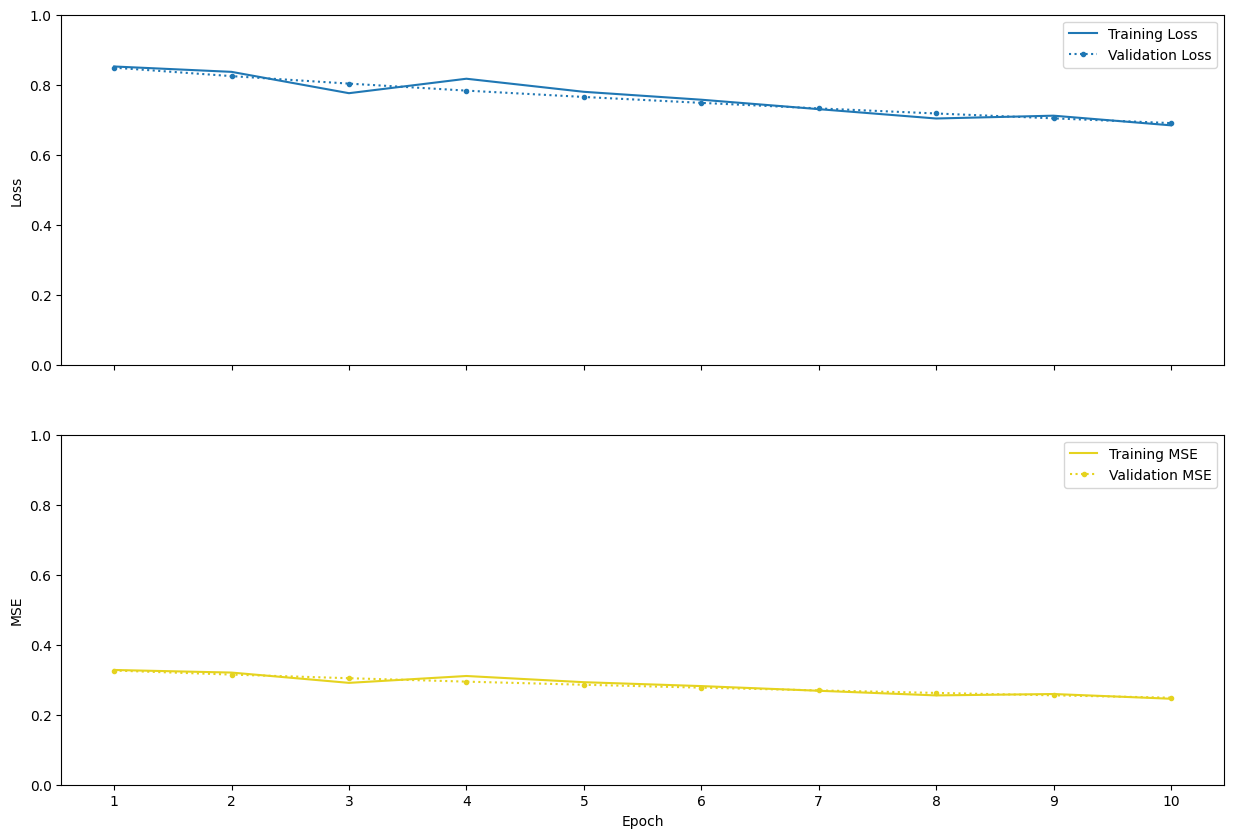

In [38]:
# Time to plot our results!
%pylab inline
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(15,10))

ax[0].plot(history.history['loss'],color='#1f77b4',label='Training Loss')
ax[0].plot(history.history['val_loss'],linestyle=':',marker='o',markersize=3,color='#1f77b4',label='Validation Loss')
ax[0].set_ylabel('Loss')
ax[0].set_ylim(0.0,1)
ax[0].legend()

ax[1].plot(history.history['mean_squared_error'],color='#E5D31F',label='Training MSE')
ax[1].plot(history.history['val_mean_squared_error'],linestyle=':',marker='o',markersize=3,color='#E5D31F',label='Validation MSE')
ax[1].set_ylabel('MSE')
ax[1].legend(loc="lower right")

ax[1].set_xticks(history.epoch)
ax[1].set_xticklabels(range(1,len(history.epoch)+1, 1))
ax[1].set_xlabel('Epoch')
ax[1].set_ylim(0.0,1)

plt.legend()

In [39]:
# Time to evaluate the model
eval = model.evaluate(
    x = test_data_rdy,
    verbose = 2,
    steps = 1)

1/1 - 1s - loss: 0.6700 - mean_squared_error: 0.2385 - 712ms/epoch - 712ms/step


In [40]:
# And to perform a prediction on our test dataset
pred = model.predict(
    x = test_data_rdy,
    verbose = 2,
    steps = 1
)

1/1 - 1s - 581ms/epoch - 581ms/step


In [41]:
# We can print the content of our test dataset
print(test_data_rdy.take(1).get_single_element())

(<tf.Tensor: shape=(1, 3, 2), dtype=float32, numpy=
array([[[ -5.540222 , -20.295975 ],
        [ -5.3314714, -17.927376 ],
        [ -9.277018 , -16.801119 ]]], dtype=float32)>, <tf.Tensor: shape=(1, 3, 1), dtype=float32, numpy=
array([[[0.],
        [0.],
        [1.]]], dtype=float32)>)


In [42]:
# And the predictions of the model
print(pred[0])

[0.5226961  0.49185935 0.55246365]


In [43]:
# Time to save our model!
modelDir = '/content/drive/MyDrive/RAMI_DL/mining_model'
tf.keras.models.save_model(model, modelDir)

In [44]:
# We can see a resume of our small model
model.summary()

Model: "lstmNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 array (InputLayer)          [(None, 3, 2)]            0         
                                                                 
 lstm_layer_1 (LSTM)         (None, 3, 32)             4480      
                                                                 
 lstm_layer_2 (LSTM)         (None, 32)                8320      
                                                                 
 output_layer (Dense)        (None, 3)                 99        
                                                                 
Total params: 12,899
Trainable params: 12,899
Non-trainable params: 0
_________________________________________________________________


## Model Application

In [45]:
# We will calculate the amount of time it takes to run the model and define some parameters
modelDir = '/content/drive/MyDrive/RAMI_DL/mining_model'
img_path = '/content/drive/MyDrive/RAMI_DL/RAMI_DL_Img.tif'
out_path = '/content/drive/MyDrive/RAMI_DL/RAMI_DL_Img_pred.tif'
start = time.time()

In [46]:
# We can load the model using the keras API
loaded_model = tf.keras.models.load_model(modelDir)

In [47]:
# Check the loaded model
loaded_model.summary()

Model: "lstmNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 array (InputLayer)          [(None, 3, 2)]            0         
                                                                 
 lstm_layer_1 (LSTM)         (None, 3, 32)             4480      
                                                                 
 lstm_layer_2 (LSTM)         (None, 32)                8320      
                                                                 
 output_layer (Dense)        (None, 3)                 99        
                                                                 
Total params: 12,899
Trainable params: 12,899
Non-trainable params: 0
_________________________________________________________________


In [48]:
# Create a blank img, to store metadata and geocodify the predictions
img = gdal.Open(img_path, gdal.GA_ReadOnly)

In [49]:
# Notice the shape of the original image
print(img.ReadAsArray().shape)

(6, 189, 265)


In [50]:
# Load the image values as an array, then apply transpose
img_array = img.ReadAsArray().transpose()

In [51]:
# Print the shape of the array
print(img_array.shape)

(265, 189, 6)


In [52]:
# Reshape the image, to generate predictions, the shape should be batch, step, bands
img_rdy = np.reshape(img_array, [img_array.shape[0] * img_array.shape[1], 3, 2])
print(img_rdy.shape)

(50085, 3, 2)


In [53]:
# Apply the model on the processed array
predictions = model.predict(img_rdy, verbose = 1)

1566/1566 [==============================] - 4s 2ms/step


In [54]:
# See the shape of our predictions
print(predictions.shape)

(50085, 3)


In [55]:
# The predictions must be reshaped to the same dimensions of the input image
# Notice that GDAL reads data differently (bands, height, width), that's why we apply transpose
final = np.reshape(predictions, [265, 189, 3]).transpose()
print(final.shape)

(3, 189, 265)


In [56]:
# Now we will register a new image using GDAL
driver = gdal.GetDriverByName('GTiff')
driver.Register()

# We'll use the shapes of the output
outDataset = driver.Create(out_path, final.shape[2], final.shape[1], final.shape[0], gdal.GDT_Float32)
outDataset.SetProjection(img.GetProjection())
outDataset.SetGeoTransform(img.GetGeoTransform())
outDataset.GetRasterBand(1).WriteArray(final[0, :, :], 0, 0)
outDataset.GetRasterBand(2).WriteArray(final[1, :, :], 0, 0)
outDataset.GetRasterBand(3).WriteArray(final[2, :, :], 0, 0)

del outDataset

In [57]:
end = time.time()
print('Duration (minutes): ', (end-start)/60)

Duration (minutes):  0.17834444443384806


What are your results?

<img src="https://raw.githubusercontent.com/SERVIR-Amazonia/Peru-tensorflow-training/main/notebooks/images/RAMI_results.PNG" width="650px">

How can we interpretate our results?

<img src="https://raw.githubusercontent.com/SERVIR-Amazonia/Peru-tensorflow-training/main/notebooks/images/RAMI_NICFI.PNG" width="650px">